In [1]:
from os import listdir
from os.path import isdir, join
from tensorflow.keras import layers, models
import numpy as np

In [2]:
# Create List of all targets (minus background noise)
dataset_path = 'C:\\Users\\multicampus\Desktop\\data_speech_commands_v0.02.tar\\data_speech_commands_v0.02'
all_targets = all_targets = [name for name in listdir(dataset_path) if isdir(join(dataset_path, name))]
all_targets.remove('_background_noise_')
print(all_targets)

['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']


In [3]:
# step 1에서 만든 기능 세트 파일의 경로 설정
# Settings
feature_sets_path = 'C:\\Users\\multicampus\\Desktop\pjt_2\\s03p13d204\embedded\\tensorflow\\audio_recognition'
# 신경망 모델 저장 파일
feature_sets_filename = 'all_targets_mfcc_sets.npz'
# 파일이름을 지정하고 weights를 정의 할 것이다.

model_filename = 'wake_word_stop_model.h5'
# 위를 보고 사용가능한 단어여야 한다.

wake_word = 'stop'

In [4]:
# 데이터 세트의 대상 numpy를 사용하여 기능 세트 파일을 로드한다.
# Load feature sets
feature_sets = np.load(join(feature_sets_path, feature_sets_filename))
print(feature_sets.files)
print(len(feature_sets.files[0]))

['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']
7


In [5]:
# 텐서는 여러개로 정렬된 데이터 모음이다
# Assign feature sets
x_train = feature_sets['x_train']
y_train = feature_sets['y_train']
x_val = feature_sets['x_val']
y_val = feature_sets['y_val']
x_test = feature_sets['x_test']
y_test = feature_sets['y_test']

In [6]:
# 행렬의 크기는 단순히 2차원 텐서
# 즉 MFCC로 생성한 것은 단순한 행렬
# 첫번째 - 해당 세트의 셈플 수
# 나머지 2개는 계수의 수와 집합의 수이다.
# Look at tensor dimensions
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(77482, 16, 16)
(9688, 16, 16)
(9686, 16, 16)


In [7]:
# peek at labels
print(y_val)

[ 0. 13. 11. ...  5. 31.  9.]


In [8]:
print(len(all_targets))

35


In [9]:
# Convert ground truth arrays to one wake word (1) and 'other' (0)
# 0,1로 바꿔야 한다.
wake_word_index = all_targets.index(wake_word)
y_train = np.equal(y_train, wake_word_index).astype('float64')
y_val = np.equal(y_val, wake_word_index).astype('float64')
y_test = np.equal(y_test, wake_word_index).astype('float64')

In [10]:
# Peek at Labels after conversion
print(y_val)

[0. 0. 0. ... 0. 0. 0.]


In [11]:
# what percentage of 'stop' appear in validation Labels
print(sum(y_val) / len(y_val))
print(1 - sum(y_val) / len(y_val))

0.03746903385631709
0.9625309661436829


In [12]:
# View the dimensions of our input data
print(x_train.shape)

(77482, 16, 16)


In [13]:
# CNN for TF expects (batch, height, width, channels)
# so we reshape the input tensors with a "color" channel of 1
x_train = x_train.reshape(x_train.shape[0],
                          x_train.shape[1],
                          x_train.shape[2],
                          1)
x_val = x_val.reshape(x_val.shape[0],
                      x_val.shape[1],
                      x_val.shape[2],
                      1)
x_test = x_test.reshape(x_test.shape[0],
                       x_test.shape[1],
                       x_test.shape[2],
                       1)
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(77482, 16, 16, 1)
(9688, 16, 16, 1)
(9686, 16, 16, 1)


In [14]:
# 요소가 하나뿐이기 때문에 배열이 하나다.
# Input shape for CNN is size of MFCC of 1 sample
sample_shape = x_test.shape[1:]
print(sample_shape)

(16, 16, 1)


In [15]:
# Build model
# Based on: https://www.geeksforgeeks.org/python-image-classification-using-keras/

model = models.Sequential()
model.add(layers.Conv2D(32,
                       (2, 2),
                       activation='relu',
                       input_shape=sample_shape))
model.add(layers.MaxPooling2D(pool_size=(2, 2))) 
  
model.add(layers.Conv2D(32, (2, 2), activation='relu')) 
model.add(layers.MaxPooling2D(pool_size=(2, 2))) 
  
model.add(layers.Conv2D(64, (2, 2), activation='relu')) 
model.add(layers.MaxPooling2D(pool_size=(2, 2))) 
  
# Classifier
model.add(layers.Flatten()) 
model.add(layers.Dense(64)) 
model.add(layers.Activation('relu')) 
model.add(layers.Dropout(0.5)) 
model.add(layers.Dense(1, activation='sigmoid')) 

In [16]:
# 위의 출력은 다음과 함께 완전히 연결되거나 조밀한 신경망에 공급
# display model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 15, 15, 32)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 32)          4128      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 64)          8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0

In [17]:
# Add training parameters to model
# MFCC와 모양과 크기가 같은 다른 것들과 함께 세트로 구성
model.compile(loss='binary_crossentropy',
             optimizer='rmsprop',
             metrics=['acc'])

In [18]:
# hyperparameters - 자동으로 업데이트 되지 않음
# 모델 설정 했으니 학습해야한다.
# loss 값 설정
model.compile(loss='binary_crossentropy',
             optimizer='rmsprop',
             metrics=['acc'])

In [19]:
# fit 함수 호출하여 수행하고 훈련을 전달한다.
# Train
history = model.fit(x_train,
                   y_train,
                   epochs=40,
                   batch_size=1000,
                   validation_data=(x_val, y_val))

# 실측 답변, 샘플, 통과한 epochs 수, 배치 크기
# epochs와 batch_size를 가지고 놀면서 정확도를 높일 수 있다.
# 보이지 않는 데이터를 예측시 얼마나 잘 수행되는지를 확인

Epoch 1/40
78/78 [==============================] - 5s 65ms/step - loss: 0.1781 - acc: 0.9538 - val_loss: 0.1251 - val_acc: 0.9625
Epoch 2/40
78/78 [==============================] - 5s 60ms/step - loss: 0.1301 - acc: 0.9632 - val_loss: 0.1095 - val_acc: 0.9626
Epoch 3/40
78/78 [==============================] - 5s 66ms/step - loss: 0.1115 - acc: 0.9660 - val_loss: 0.0883 - val_acc: 0.9732
Epoch 4/40
78/78 [==============================] - 4s 57ms/step - loss: 0.0974 - acc: 0.9701 - val_loss: 0.0882 - val_acc: 0.9733
Epoch 5/40
78/78 [==============================] - 5s 64ms/step - loss: 0.0902 - acc: 0.9721 - val_loss: 0.0815 - val_acc: 0.9730
Epoch 6/40
78/78 [==============================] - 5s 63ms/step - loss: 0.0843 - acc: 0.9733 - val_loss: 0.0655 - val_acc: 0.9787
Epoch 7/40
78/78 [==============================] - 6s 71ms/step - loss: 0.0789 - acc: 0.9754 - val_loss: 0.0647 - val_acc: 0.9796
Epoch 8/40
78/78 [==============================] - 5s 65ms/step - loss: 0.0742 - a

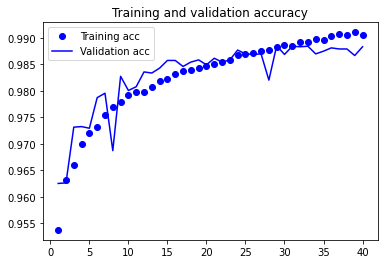

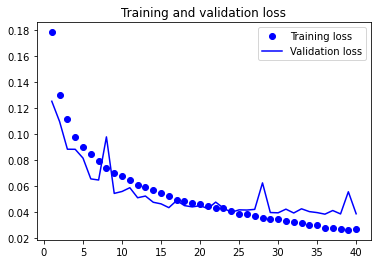

In [20]:
# 마지막 부분을 확인하면 val_loss는 모델이 얼마나 잘 수행되었는지 알려주는 정확도 점수
# val_acc는 모델이 얼마나 잘 수행되었는지 알려주는 검증 정확도 점수
# 교차 검증하기 위해 정확도와 손실을 함수ㄹ확도가 주어진 두 개의 플롯을 만들자.
# Plot results
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [21]:
# 몇 번의 에포크 이후에도 커브가 여전히 심하게 흔들리면 훈련중 문제가 발생한거다.


In [22]:
#save the model as a fil
models.save_model(model, model_filename)

In [23]:
# 새로운 데이터에 대한 예측을 하려면, 먼저 따로 설정한 테스트데이터를 사용하여테스트 할 수 있다.
# 아래는 단어를 가리키는 훈련 데이터에 대한 모든 색인을 인쇄한다.
for idx, y in enumerate(y_test):
    if y == 1:
        print(idx)

26
84
90
128
143
158
229
236
237
251
277
307
325
391
399
427
455
464
483
487
495
533
575
591
618
734
756
879
926
942
952
997
1007
1010
1057
1098
1099
1162
1226
1249
1276
1294
1295
1313
1366
1371
1379
1385
1389
1391
1397
1410
1458
1501
1543
1554
1580
1636
1675
1693
1750
1753
1764
1765
1839
1854
1877
1880
1930
1955
1966
1977
1985
2039
2052
2063
2072
2089
2107
2135
2199
2219
2235
2299
2300
2315
2358
2394
2406
2463
2503
2578
2581
2602
2636
2640
2660
2689
2699
2716
2732
2744
2747
2788
2808
2849
2855
2883
2951
2957
2997
3104
3133
3155
3184
3278
3279
3296
3356
3374
3376
3394
3513
3518
3577
3599
3616
3619
3667
3699
3803
3814
3839
3876
3895
3944
3972
3979
4004
4015
4053
4056
4078
4086
4088
4098
4124
4170
4272
4280
4300
4317
4336
4337
4340
4365
4385
4423
4449
4504
4523
4527
4530
4601
4621
4660
4709
4738
4750
4761
4780
4782
4838
4839
4858
4884
4975
5008
5125
5141
5206
5209
5212
5273
5313
5347
5385
5401
5403
5474
5478
5513
5551
5581
5603
5604
5623
5657
5658
5686
5694
5704
5708
5715
5811
5823
5839


In [24]:
# 파일에서 모델을 로드하고 10에서 출력을 예측한다. 0.5 이상이 우리의 것.
# TEST: Load model and run it against test set
model = models.load_model(model_filename)
for i in range(0, 200):
    print('Answer:', y_test[i], 'Prediction:', model.predict(np.expand_dims(x_test[i], 0)))

Answer: 0.0 Prediction: [[2.5179775e-06]]
Answer: 0.0 Prediction: [[3.852676e-08]]
Answer: 0.0 Prediction: [[2.224919e-08]]
Answer: 0.0 Prediction: [[1.6097215e-07]]
Answer: 0.0 Prediction: [[1.3017696e-09]]
Answer: 0.0 Prediction: [[1.5871381e-05]]
Answer: 0.0 Prediction: [[2.2824565e-08]]
Answer: 0.0 Prediction: [[1.2636288e-08]]
Answer: 0.0 Prediction: [[5.7667284e-09]]
Answer: 0.0 Prediction: [[5.2499853e-09]]
Answer: 0.0 Prediction: [[3.4780858e-09]]
Answer: 0.0 Prediction: [[6.923653e-05]]
Answer: 0.0 Prediction: [[0.0002054]]
Answer: 0.0 Prediction: [[4.8230657e-08]]
Answer: 0.0 Prediction: [[1.7779927e-06]]
Answer: 0.0 Prediction: [[1.7117323e-08]]
Answer: 0.0 Prediction: [[0.00036186]]
Answer: 0.0 Prediction: [[0.00012624]]
Answer: 0.0 Prediction: [[8.444486e-09]]
Answer: 0.0 Prediction: [[0.00115177]]
Answer: 0.0 Prediction: [[2.7448417e-08]]
Answer: 0.0 Prediction: [[1.5968068e-08]]
Answer: 0.0 Prediction: [[3.6564853e-07]]
Answer: 0.0 Prediction: [[4.709799e-06]]
Answer: 0.

In [25]:
model.evaluate(x=x_test, y=y_test)

303/303 [==============================] - 0s 1ms/step - loss: 0.0409 - acc: 0.9872


[0.040948204696178436, 0.987197995185852]

In [26]:
# 위의 결과가 좀 더 검증 정확도에 가깝다. 우리의 모델은 1초의 오디오 클립을 예측할 때 약 98.4% 정확도이다.
